In [1]:
import confirm.outlaw.nb_util as nb_util

nb_util.setup_nb()
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from numpy import sqrt
import jax
import jax.numpy as jnp
from scipy.special import logit, expit

In [2]:
At = lambda t, n: -n * jnp.log(1 - jax.scipy.special.expit(t))
g = lambda t, n, x: t * x - At(t, n)
dg = jax.grad(g)
dg_vmap = jax.vmap(dg, in_axes=(None, None, 0))

In [3]:
def simulate(n, p, nsims, thresh):
    delta = 0.01
    np.random.seed(0)
    samples = scipy.stats.binom.rvs(n, p, size=nsims)
    reject = samples >= thresh
    typeI_sum = np.sum(reject)
    typeI_score = np.sum(reject * (samples - n * p))
    return typeI_sum, typeI_score

In [4]:
def C_numerical(n_arm_samples, t, hp, hq):
    p = expit(t)
    xs = jnp.arange(n_arm_samples + 1).astype(jnp.float64)
    eggq = jnp.abs(dg_vmap(t, n_arm_samples, xs)) ** hq
    return sum(eggq * scipy.stats.binom.pmf(xs, n_arm_samples, p)) ** (1 / hq)

def holder_odi(typeI_sum, n_arm_samples, nsims, t_path, hp, delta=0.01):
    hq = 1 / (1 - 1 / hp)
    C = [C_numerical(n_arm_samples, t, hp, hq) for t in t_path]
    f0 = scipy.stats.beta.ppf(1 - delta, typeI_sum + 1, nsims - typeI_sum)
    return ((t_path - t_path[0]) * C / hq + f0 ** (1 / hq)) ** hq

In [5]:
def holder_odi_n(typeI_sum, n_arm_samples, nsims, t_path, hp, delta=0.01):
    hq = 1 / (1 - 1 / hp)
    f0 = scipy.stats.beta.ppf(1 - delta, typeI_sum + 1, nsims - typeI_sum)

    def derivs(t, y):
        cur_f = y[0]
        return C_numerical(n_arm_samples, t, hp, hq) * cur_f ** (1 / hp)
    
    t = t_path[0] 
    dt = t_path[-1] - t
    ode = scipy.integrate.solve_ivp(derivs, (t, t+dt), [f0], t_eval=t_path, rtol=1e-10, atol=1e-10)
    return ode['y'][0]

In [6]:
def taylor(typeI_sum, typeI_score, n_arm_samples, nsims, t_path, delta=0.01, delta_prop_0to1=0.5):
    f0 = scipy.stats.beta.ppf(1 - (delta * delta_prop_0to1), typeI_sum + 1, nsims - typeI_sum)

    grad_est = typeI_score / nsims
    covar = n_arm_samples * expit(t_path[0]) * (1 - expit(t_path[0]))
    grad_bound = np.sqrt(covar / nsims * (1 / ((1 - delta_prop_0to1) * delta) - 1))

    p = expit(t_path)
    hess_bound = n_arm_samples * p * (1 - p)

    t = t_path[0]
    return f0 + (grad_est + grad_bound) * (t_path - t) + 0.5 * hess_bound * (t_path - t) ** 2

In [7]:
def copt(a, p):
    return 1 / (1 + ((1-a)/a)**(1/(p-1)))

def centered_odi(typeI_sum, n_arm_samples, nsims, t_path, hp, delta=0.01, copt_f=copt, constant_c=False):
    hq = 1 / (1 - 1 / hp)
    f0 = scipy.stats.beta.ppf(1 - delta, typeI_sum + 1, nsims - typeI_sum)
    c = copt_f(f0, hp) if constant_c else None

    def derivs(t, y):
        cur_f = y[0]
        if not constant_c:
            c = copt_f(cur_f, hp)
        cur_Fc = cur_f * (1 - c) ** hp + (1 - cur_f) * c ** hp
        return C_numerical(n_arm_samples, t, hp, hq) * cur_Fc ** (1 / hp)
    
    t = t_path[0] 
    dt = t_path[-1] - t
    centeredode = scipy.integrate.solve_ivp(derivs, (t, t+dt), [f0], t_eval=t_path, rtol=1e-10, atol=1e-10)
    return centeredode['y'][0]

## Comparing bounds

In [8]:
def experiment(n, p, dt, nsims, thresh, hp, cp, hp_n=None, include_taylor=True):
    t = logit(p)
    t_path = np.linspace(t, t + dt, 200)
    true_err = 1 - scipy.stats.binom.cdf(thresh - 1, n, expit(t_path))
    typeI_sum, typeI_score = simulate(n, p, nsims, thresh)

    if hp is not None:
        hob = holder_odi(typeI_sum, n, nsims, t_path, hp)
        plt.plot(t_path, hob, 'b-', label=f'holder({hp})')

    if hp_n is not None:
        hobn = holder_odi_n(typeI_sum, n, nsims, t_path, hp_n)
        plt.plot(t_path, hobn, 'b:', label=f'holder-numerical({hp_n})')

    if include_taylor:
        tb = taylor(typeI_sum, typeI_score, n, nsims, t_path)
        plt.plot(t_path, tb, 'r--', label='taylor')

    if cp is not None:
        cob = centered_odi(typeI_sum, n, nsims, t_path, cp)
        plt.plot(t_path, cob, 'k:', label=f'centered({cp})')

    plt.plot(t_path, true_err, 'k-', label='true')
    plt.xlabel(r'$\theta$')
    plt.ylabel('type I error')
    plt.legend()

In [9]:
experiment(50, 0.2, 0.2, 10000, 20, 1.2, 1.2)

Error in callback <function _draw_all_if_interactive at 0x7f03551d3d00> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error ../38397cb37a9d3aa452478a7242fcbec5.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../38397cb37a9d3aa452478a7242fcbec5.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.8 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on 38397cb37a9d3aa452478a7242fcbec5.log.




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error ../38397cb37a9d3aa452478a7242fcbec5.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../38397cb37a9d3aa452478a7242fcbec5.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.8 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on 38397cb37a9d3aa452478a7242fcbec5.log.




<Figure size 640x480 with 1 Axes>

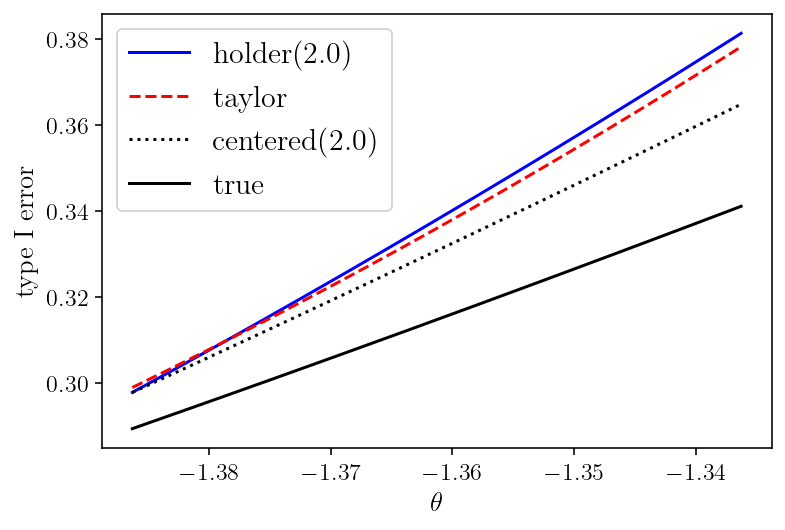

In [ ]:
experiment(50, 0.2, 0.05, 10000, 12, 2.0, 2.0)

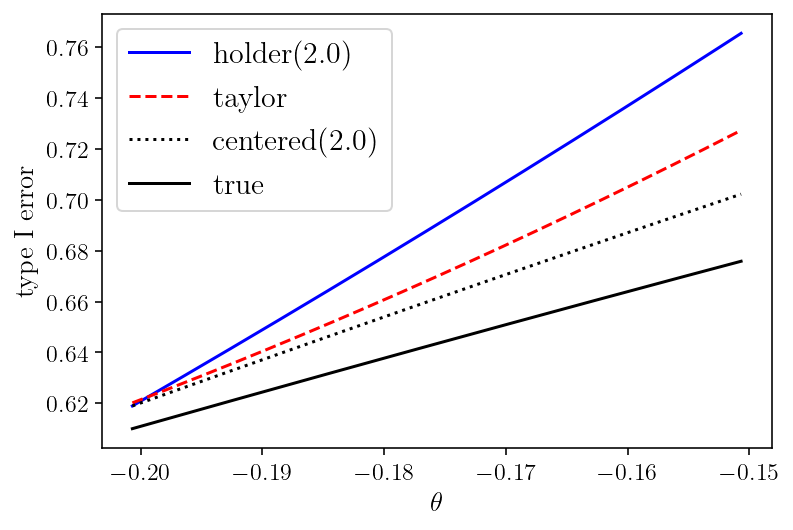

In [ ]:
experiment(50, 0.45, 0.05, 10000, 22, 2.0, 2.0)

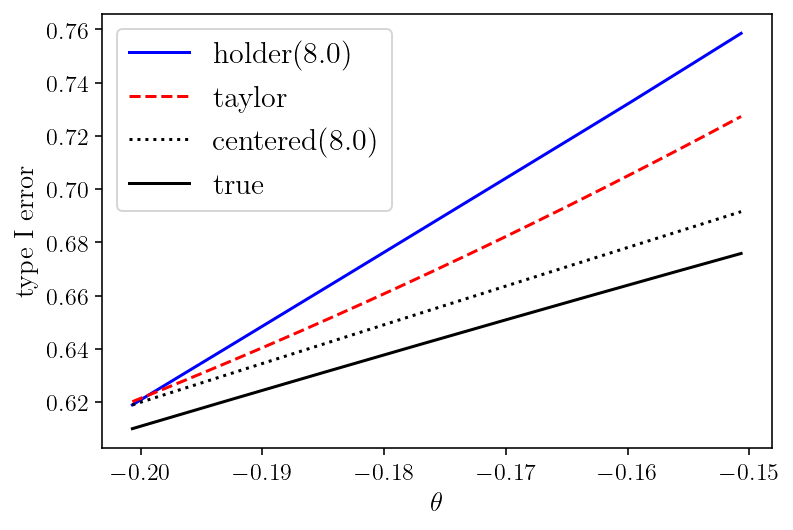

In [ ]:
experiment(50, 0.45, 0.05, 10000, 22, 8.0, 8.0)

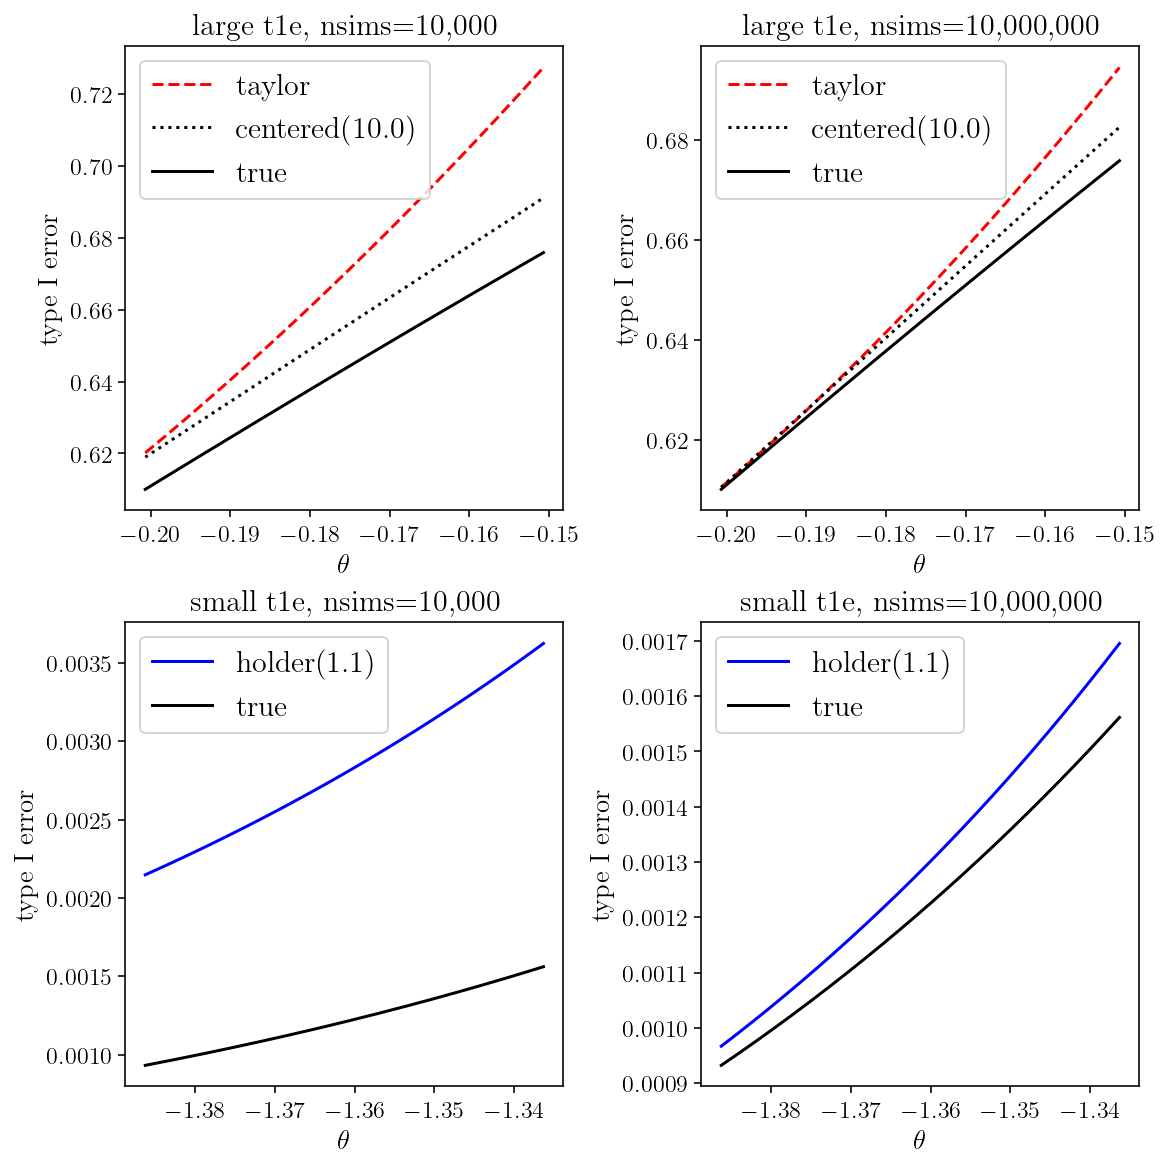

In [82]:
plt.subplots(2, 2, figsize=(8, 8), constrained_layout=True)
plt.subplot(2,2,1)
plt.title('large t1e, nsims=10,000')
experiment(50, 0.45, 0.05, 10000, 22, None, 10.0)
plt.subplot(2,2,2)
plt.title('large t1e, nsims=10,000,000')
experiment(50, 0.45, 0.05, 10000000, 22, None, 10.0)
plt.subplot(2,2,3)
plt.title('small t1e, nsims=10,000')
experiment(50, 0.2, 0.05, 10000, 20, 1.1, None, include_taylor=False)
plt.subplot(2,2,4)
plt.title('small t1e, nsims=10,000,000')
experiment(50, 0.2, 0.05, 10000000, 20, 1.1, None, include_taylor=False)
plt.show()

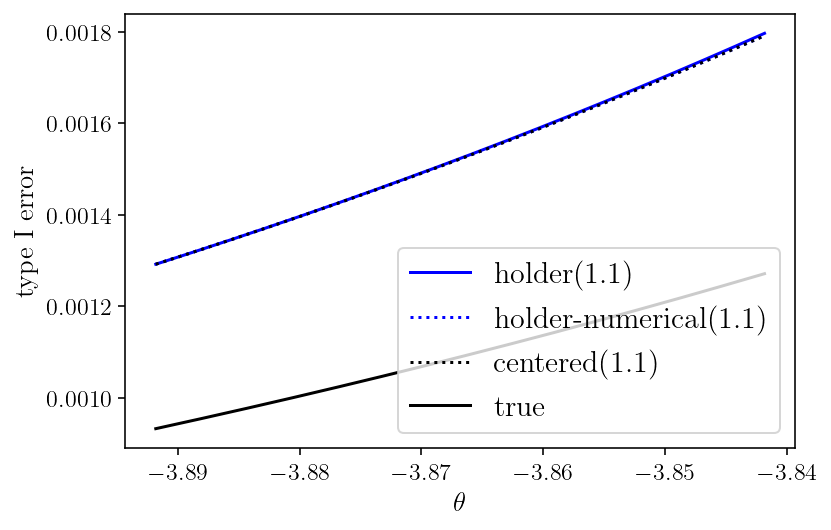

In [111]:
experiment(100, 0.02, 0.05, 100000, 8, 1.1, 1.1, 1.1, include_taylor=False)